# Cell type annotation prediction

Run this notebook on google colab to use a free GPU!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Cell-Type-Annotation.ipynb)

In this notebook, we aim to predict cell type annotations based on gene expression profiles using Foundation Models. 

Following a tutorial from [scGPT](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Annotation.ipynb), we will:

* Use the pre-trained scGPT model to generate embeddings from gene expression profiles.
* Train a smaller neural network on these embeddings to predict cell types, rather than fine-tuning the entire scGPT model.

Comparison with [Geneformer](https://www.nature.com/articles/s41586-023-06139-9.epdf?sharing_token=u_5LUGVkd3A8zR-f73lU59RgN0jAjWel9jnR3ZoTv0N2UB4yyXENUK50s6uqjXH69sDxh4Z3J4plYCKlVME-W2WSuRiS96vx6t5ex2-krVDS46JkoVvAvJyWtYXIyj74pDWn_DutZq1oAlDaxfvBpUfSKDdBPJ8SKlTId8uT47M%3D):
* We will apply the same approach to another Foundation Model, Geneformer, and compare the prediction results from both models to evaluate their performance.

This approach significantly reduces the time and computational resources required, making it more efficient while still achieving reliable predictions.

Comparison with [Celltypist](https://github.com/Teichlab/celltypist):
* We will also compare the prediction results from both Foundation models to a model built on the basis of logistic regression classifiers (supervised learning) using Celltypist. 



### Installing required packages and importing libraries

In [1]:
!pip install tensorflow_addons
!pip install git+https://github.com/helicalAI/helical.git@main | tail -n 1

  Running command git clone --filter=blob:none --quiet https://github.com/helicalAI/helical.git /private/var/folders/dl/jdlpx0rd1sngyrhc_xk9zmdw0000gn/T/pip-req-build-mqm7ffz_
  Running command git checkout -b main --track origin/main
  Switched to a new branch 'main'
  branch 'main' set up to track 'origin/main'.


In [2]:
!pip install tensorboard

In [3]:
pip install celltypist

Note: you may need to restart the kernel to use updated packages.


In [4]:
# %load_ext tensorboard # uncomment to use tensorboard

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from tensorflow_addons.metrics import F1Score
import os
import requests
import numpy as np
import scanpy as sc
import torch
import celltypist
from celltypist import models
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig

/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.13.0-rc1 and is not supported. 
Some things might work, some t

### Downloading the training and evaluation sets

To build and assess the performance of our machine learning models, we need to work with two types of datasets: a Training set and an Evaluation set. For that, we will use a Multiple Sclerosis (MS) dataset. 

As described in the [scGPT paper](https://www.nature.com/articles/s41592-024-02201-0):
> The MS dataset was accessed from [EMBL-EBI](https://www.ebi.ac.uk/gxa/sc/experiments/E-HCAD-35). Nine healthy control samples and 12 MS samples are included in the dataset. The control samples are split into the reference set (Training set) and held out the MS samples as the query set for evaluation (Evaluation set).  Three cell types were excluded: B cells, T cells and oligodendrocyte B cells, which only existed in the query dataset. The final cell counts were 7,844 in the training reference set and 13,468 in the query set. The provided cell type labels from the original publication were used as ground truth labels for evaluation. The data-processing protocol involved selecting HVGs to retain 3,000 genes.

- **Training set**  `c_data.h5ad`: This dataset is used to train the model. During training, the model learns to understand the patterns and relationships within the data, allowing it to make predictions.

- **Evaluation set**  `ms_default.h5ad`: This dataset is used to evaluate the model's performance. It helps us understand how well the model generalizes to new, unseen data by providing an unbiased assessment of its predictive capabilities.

Following the methodology from a [paper](https://www.biorxiv.org/content/10.1101/2023.10.24.563625v1) comparing scGPT and Geneformer, we will download these datasets. The evaluation set was retrieved from their [Google Drive](https://drive.google.com/drive/folders/1bNOrB0ukkAuGtcocdvctSVOaAUG6uJ8l), and the training set was obtained from scGPT [here](https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v). To make your life easier, you can also download it from our Blob core as shown below.


In [6]:
def download_files(files: list[str])-> None:

    for filename in files:
        url = f"https://helicalpackage.blob.core.windows.net/helicalpackage/data/{filename}"

        # Check if the file already exists in the current directory
        if os.path.exists(filename):
            print(f"Files already exist. Skipping downloads.")
        else:
            response = requests.get(url)
            if response.status_code == 200:
                with open(filename, "wb") as file:
                    file.write(response.content)
                print(f"Downloaded {filename} successfully.")
            else:
                print(f"Failed to download {filename}.")

In [7]:
files = ["c_data.h5ad", "ms_default.h5ad"]
download_files(files)

Files already exist. Skipping downloads.
Files already exist. Skipping downloads.


### Familiarizing ourselves with the data


Before we start training our models, it's important to understand the structure of our data. We are particularly interested in the names of the cell types we want to predict, which are saved in `adata.obs["celltype"]`.

Additionally, we need to determine the number of distinct cell types present in our dataset. This information is needed for setting up our model correctly, and for downstream evaluation metrics calculation.

In [8]:
adata = sc.read("c_data.h5ad")
adata_unseen = sc.read("ms_default.h5ad")

In [9]:
# get labels: the celltype
num_types = adata.obs["celltype"].unique().shape[0]
id2type = dict(enumerate(adata.obs["celltype"].astype("category").cat.categories))

celltypes_labels = np.array(adata.obs["celltype"].tolist())

This is all summarized in this dictionary:

In [10]:
id2type

{0: 'PVALB-expressing interneuron',
 1: 'SST-expressing interneuron',
 2: 'SV2C-expressing interneuron',
 3: 'VIP-expressing interneuron',
 4: 'astrocyte',
 5: 'cortical layer 2-3 excitatory neuron A',
 6: 'cortical layer 2-3 excitatory neuron B',
 7: 'cortical layer 4 excitatory neuron',
 8: 'cortical layer 5-6 excitatory neuron',
 9: 'endothelial cell',
 10: 'microglial cell',
 11: 'mixed excitatory neuron',
 12: 'mixed glial cell?',
 13: 'oligodendrocyte A',
 14: 'oligodendrocyte C',
 15: 'oligodendrocyte precursor cell',
 16: 'phagocyte',
 17: 'pyramidal neuron?'}

# Supervised-learning (Celltypist)

In [11]:
adata_training = adata.copy()
adata_query = adata_unseen.copy()

In [12]:
sc.pp.normalize_total(adata_training, target_sum=1e4)
sc.pp.log1p(adata_training)

sc.pp.normalize_total(adata_query, target_sum=1e4)
sc.pp.log1p(adata_query)

In [13]:
new_model = celltypist.train(adata_training, labels = 'celltype', n_jobs = 10, feature_selection = False)

🍳 Preparing data before training
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['CFH', 'BAD', 'LAP3', 'CD99', 'WNT16']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")
🔬 Input data has 7844 cells and 3000 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


In [14]:
# Save the model
new_model.write('model_from_c_data.pkl')

In [15]:
new_model = models.Model.load('model_from_c_data.pkl')

In [16]:
predictions = celltypist.annotate(adata_query, model = 'model_from_c_data.pkl', majority_voting = True)

/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['CFH', 'BAD', 'LAP3', 'CD99', 'WNT16']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")
🔬 Input data has 7844 cells and 3000 genes
🔗 Matching reference genes in the model
🧬 3000 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
⛓️ Over-clustering input data with resolution set to 10
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/celltypist/classifier.py:457: FutureWarning: In the fu

In [17]:
adata_training = predictions.to_adata()

In [18]:
sc.tl.umap(adata_training)

/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1129: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [

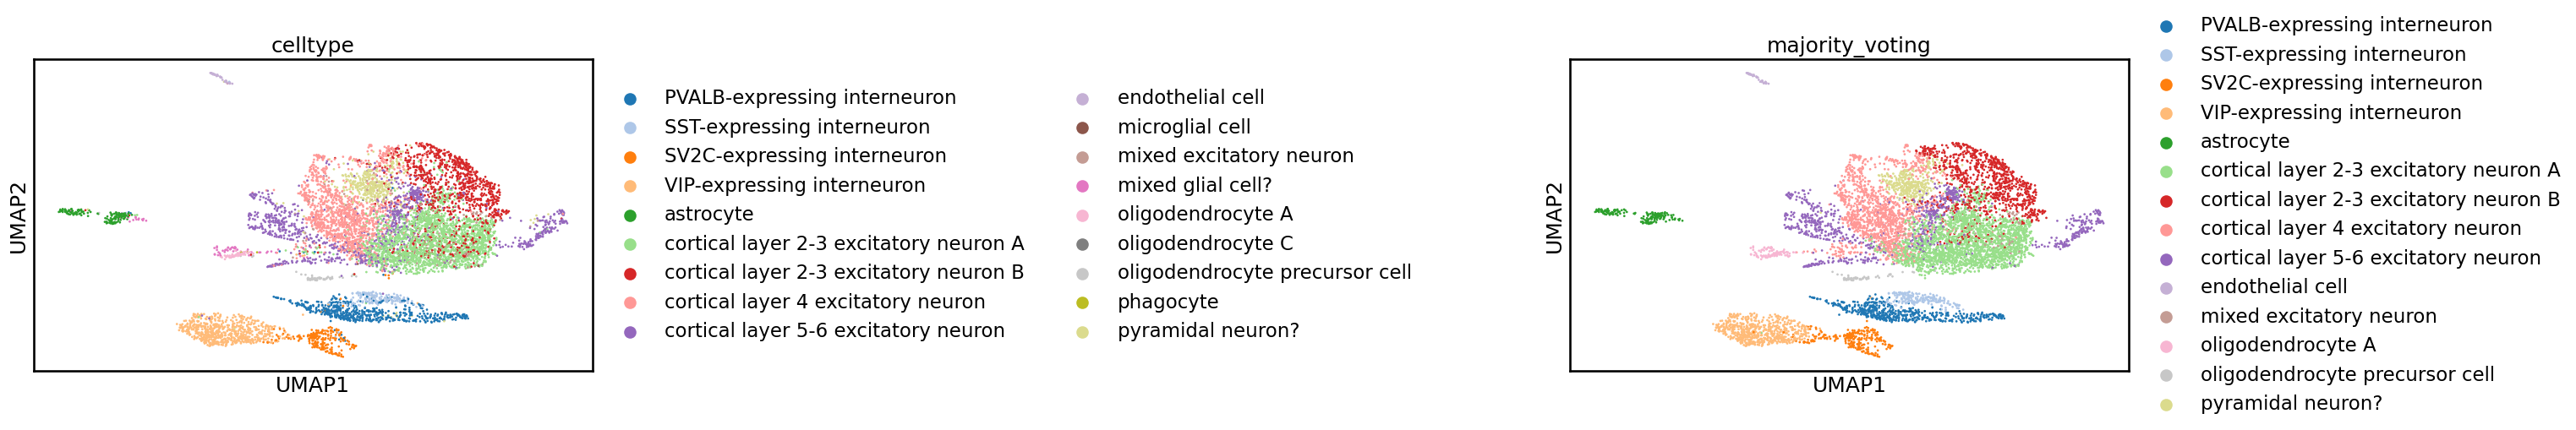

In [19]:
# Define the standard color palette
palette = sns.color_palette("tab20", 20) + sns.color_palette("tab20b", 20)  # Extending palette for more colors

# Combine all unique labels from 'celltype' and 'majority_voting'
all_labels = pd.Categorical(adata_training.obs[['celltype', 'majority_voting']].values.ravel()).categories

# Create a unified color dictionary
unified_color_dict = dict(zip(all_labels, palette[:len(all_labels)]))

# Function to match colors for any set of categories
def match_colors(base_dict, target_labels):
    return [base_dict[label] for label in target_labels if label in base_dict]

# Assign the unified colors to 'celltype' and 'majority_voting'
adata_training.uns['celltype_colors'] = match_colors(unified_color_dict, adata_training.obs['celltype'].cat.categories)
adata_training.uns['majority_voting_colors'] = match_colors(unified_color_dict, adata_training.obs['majority_voting'].cat.categories)

# Plot UMAP
sc.pl.umap(adata_training, color=['celltype', 'majority_voting'], wspace=1.5)

/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/utils

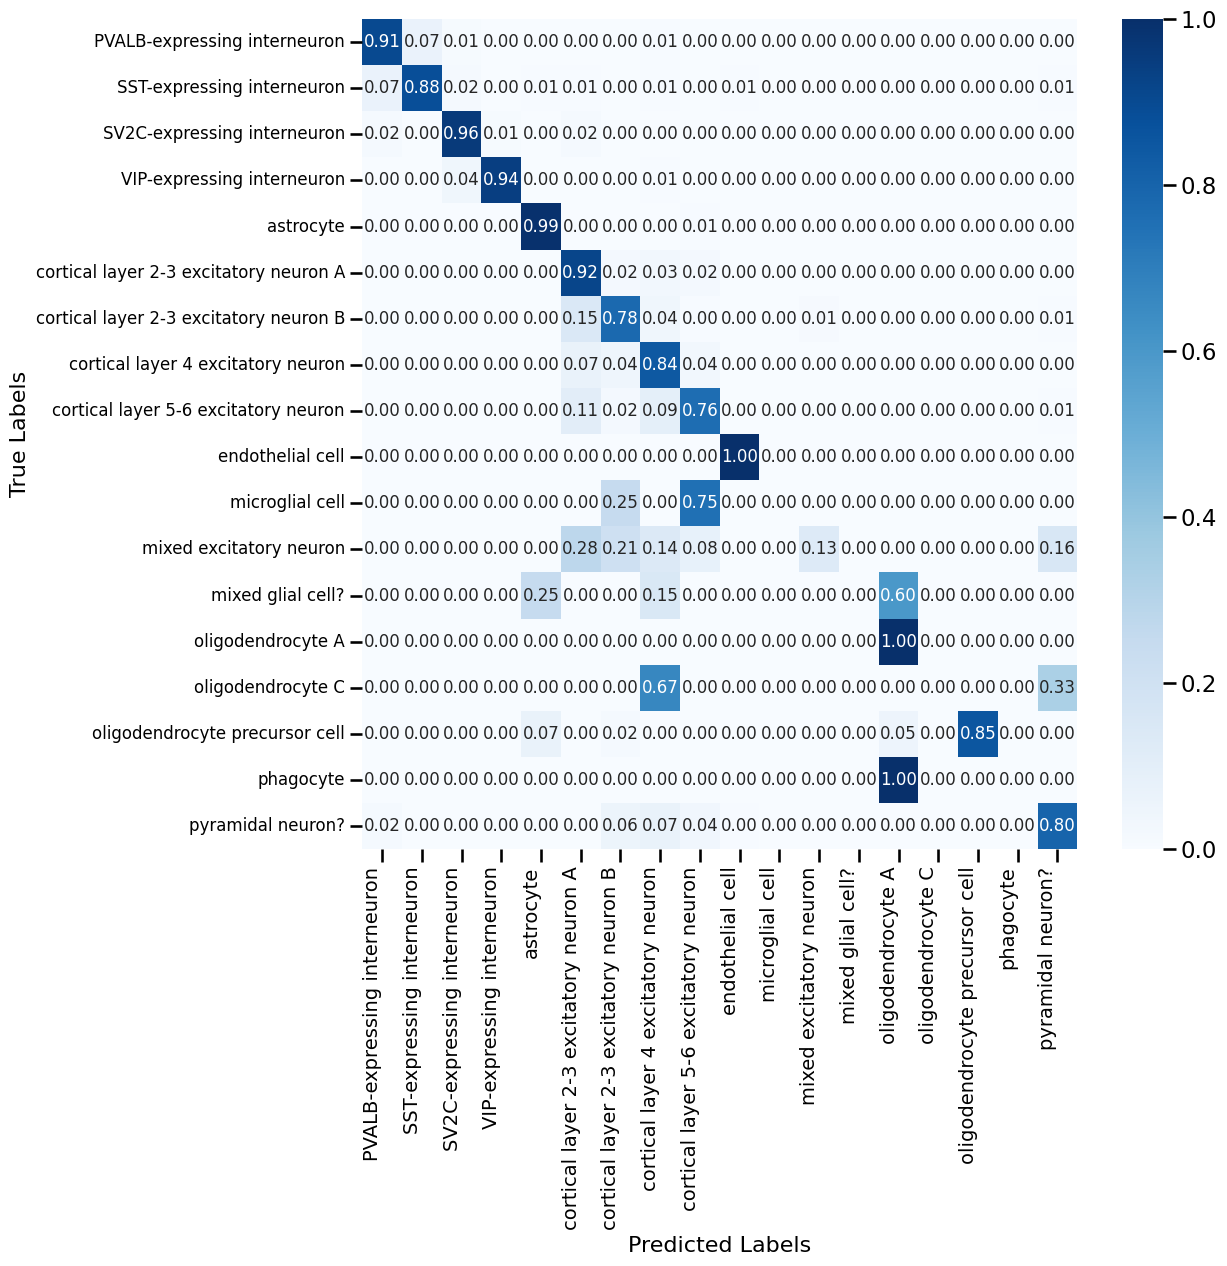

In [20]:

# Extract the true labels and predicted labels
true_labels = adata_training.obs['celltype']
pred_labels = adata_training.obs['majority_voting']

# Ensure both true and predicted labels are categorical and have the same categories
true_labels = true_labels.astype('category')
pred_labels = pred_labels.astype('category')
pred_labels = pred_labels.cat.set_categories(true_labels.cat.categories)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame for better visualization
cell_types = true_labels.cat.categories
cm_df = pd.DataFrame(cm_normalized, index=cell_types, columns=cell_types)

# Plot the confusion matrix
plt.figure(figsize=(13, 13))  # Adjusted figure size
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap="Blues", annot_kws={"size": 12})  # Adjusted annotation size
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()



To assess the performance of this self-supervised approach, we use the following metrics:

- **Accuracy**:
  - Measures overall effectiveness but can be misleading if the data is imbalanced.
  - $ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} $


- **Precision**:
  - Indicates how many of the predicted positive instances are actually correct. Useful when the cost of false positives is high.
  - $ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} $


- **Recall (Sensitivity)**:
  - Measures how well the model identifies all actual positive instances. Useful when the cost of false negatives is high.
  - $ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} $
  

- **F1 Score**: 
  - Combines precision and recall into a single metric, providing a balance between the two. Useful for imbalanced classes.
  - $ \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}} $
  

In [21]:
# Compute the accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Compute the precision
precision = precision_score(true_labels, pred_labels, average='weighted')

# Compute the recall
recall = recall_score(true_labels, pred_labels, average='weighted')

# Compute the F1 score
f1 = f1_score(true_labels, pred_labels, average='weighted')

celltypist_results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Print results in the specified style
print(f"Evaluation set accuracy: {accuracy * 100:.2f}%")
print(f"Evaluation set precision: {precision * 100:.2f}%")
print(f"Evaluation set recall: {recall * 100:.2f}%")
print(f"Evaluation set f1: {f1 * 100:.2f}%")

Evaluation set accuracy: 84.63%
Evaluation set precision: 83.82%
Evaluation set recall: 84.63%
Evaluation set f1: 83.92%


/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/utils


Next, we'll use the Helical package to obtain the embeddings of the gene expression profiles. These embeddings will serve as the input features $X$ for our smaller neural network model.

The only thing we need to specify is the gene names (`gene_name` in this case).


# scGPT

We will set up the environment to use a GPU if available, configure the scGPT model, and process the data to obtain the embeddings.

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)
data = scgpt.process_data(adata, gene_names = "gene_name")
x_scgpt = scgpt.get_embeddings(data)
x_scgpt.shape

File: '/Users/marianaquirogalondono/.cache/helical/models/scgpt/scGPT_CP/vocab.json' exists already. File is not overwritten and nothing is downloaded.
File saved to: '/Users/marianaquirogalondono/.cache/helical/models/scgpt/scGPT_CP/vocab.json'
File: '/Users/marianaquirogalondono/.cache/helical/models/scgpt/scGPT_CP/best_model.pt' exists already. File is not overwritten and nothing is downloaded.
File saved to: '/Users/marianaquirogalondono/.cache/helical/models/scgpt/scGPT_CP/best_model.pt'
Model finished initializing.
Filtering out 192 genes to a total of 2808 genes with an id in the scGPT vocabulary.
Inference started:
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Embedding cells:   0%|          | 0/157 [00:00<?, ?it/s]/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packag

(7844, 512)

We have already prepared the numerical data (embeddings) that represent the gene expression profiles. We also need the correct answers (labels) for this data, which are the names of the cell types. Since we have 18 different cell types in this dataset and each type is a category, we convert these category labels into a format that our model can understand (one-hot encoding).

In [23]:
y = celltypes_labels
num_classes = num_types

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded, num_classes=num_classes)
y_encoded.shape

(7844, 18)

### Defining and training the model

Now we will define a neural network model and train it using the embeddings and labels we prepared.

##### Defining the model

In [24]:
input_shape = (512,)

# define the model
head_model = Sequential()
head_model.add(Dense(128, activation='relu', input_shape=input_shape))
head_model.add(Dropout(0.4))
head_model.add(Dense(32, activation='relu'))
head_model.add(Dropout(0.4))
head_model.add(Dense(num_classes, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
f1_metric = F1Score(num_classes, average='macro')
head_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=f1_metric)
head_model.summary()

At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 18)                594       
                                                                 
Total params: 70386 (274.95 KB)
Trainable params: 70386 (274.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Training the model

In [25]:
head_model_scgpt = head_model
X_train, X_test, y_train, y_test = train_test_split(x_scgpt, y_encoded, test_size=0.1, random_state=42)

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = head_model_scgpt.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/50
111/111 [==============================] - 1s 3ms/step - loss: 2.4454 - f1_score: 0.0462 - val_loss: 1.9530 - val_f1_score: 0.0530
Epoch 2/50
111/111 [==============================] - 0s 2ms/step - loss: 1.8665 - f1_score: 0.1287 - val_loss: 1.4585 - val_f1_score: 0.1734
Epoch 3/50
111/111 [==============================] - 0s 1ms/step - loss: 1.4964 - f1_score: 0.2081 - val_loss: 1.1622 - val_f1_score: 0.2873
Epoch 4/50
111/111 [==============================] - 0s 1ms/step - loss: 1.3006 - f1_score: 0.2616 - val_loss: 1.0100 - val_f1_score: 0.3292
Epoch 5/50
111/111 [==============================] - 0s 1ms/step - loss: 1.1646 - f1_score: 0.2944 - val_loss: 0.8906 - val_f1_score: 0.3779
Epoch 6/50
111/111 [==============================] - 0s 1ms/step - loss: 1.0776 - f1_score: 0.3099 - val_loss: 0.8197 - val_f1_score: 0.3831
Epoch 7/50
111/111 [==============================] - 0s 1ms/step - loss: 1.0006 - f1_score: 0.3341 - val_loss: 0.7585 - val_f1_score: 0.3938
Epoch 

##### Preparing the model for evaluation

In [26]:
predictions_nn = head_model_scgpt.predict(X_test)
y_pred = np.argmax(predictions_nn, axis=1)
y_true = np.argmax(y_test, axis=1)

25/25 [==============================] - 0s 419us/step


### Presenting the results

After training the model, we need to evaluate its performance on both the test set and a separate, unseen evaluation set. We'll define a function to calculate and present various evaluation metrics.

In [27]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [28]:
get_evaluations("Test set", y_true, y_pred)

Test set accuracy: 84.2%
Test set precision: 73.0%
Test set f1: 70.6%
Test set recall: 69.4%


/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8420382165605096,
 'precision': 0.7299322335397237,
 'f1': 0.7058060712328,
 'recall': 0.6938515153364029}

##### Loading the unseen evaluation set

Now, we will load the unseen evaluation set, process it, and make predictions using our trained model.

In [29]:
data_unseen = scgpt.process_data(adata_unseen, gene_names="gene_name")
x_unseen = scgpt.get_embeddings(data_unseen)
predictions_nn_unseen = head_model_scgpt.predict(x_unseen)

Filtering out 192 genes to a total of 2808 genes with an id in the scGPT vocabulary.
Inference started:
/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Embedding cells: 100%|██████████| 157/157 [25:53<00:00,  9.89s/it]

152/246 [=================>............] - ETA: 0s

246/246 [==============================] - 0s 645us/step


##### Double checking the cell type mapping

We should double check that the cell types are mapped to the correct cell numbers for both the training data (`c_data.h5ad`) and this new data set (`ms_default.h5a`).

In [30]:
num_types = adata_unseen.obs["celltype"].unique().shape[0]
id2type_unseen = dict(enumerate(adata_unseen.obs["celltype"].astype("category").cat.categories))
id2type_unseen == id2type

True

In [31]:
y_true_unseen = np.array(adata_unseen.obs["celltype"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.argmax(predictions_nn_unseen, axis=1)]

scgpt_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 86.9%
Evaluation set precision: 68.4%
Evaluation set f1: 68.3%
Evaluation set recall: 68.5%


/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Visualizing the classification performance per cell type

To visualize the classification performance for each cell type, we will plot a confusion matrix for the evaluation set.

<Axes: >

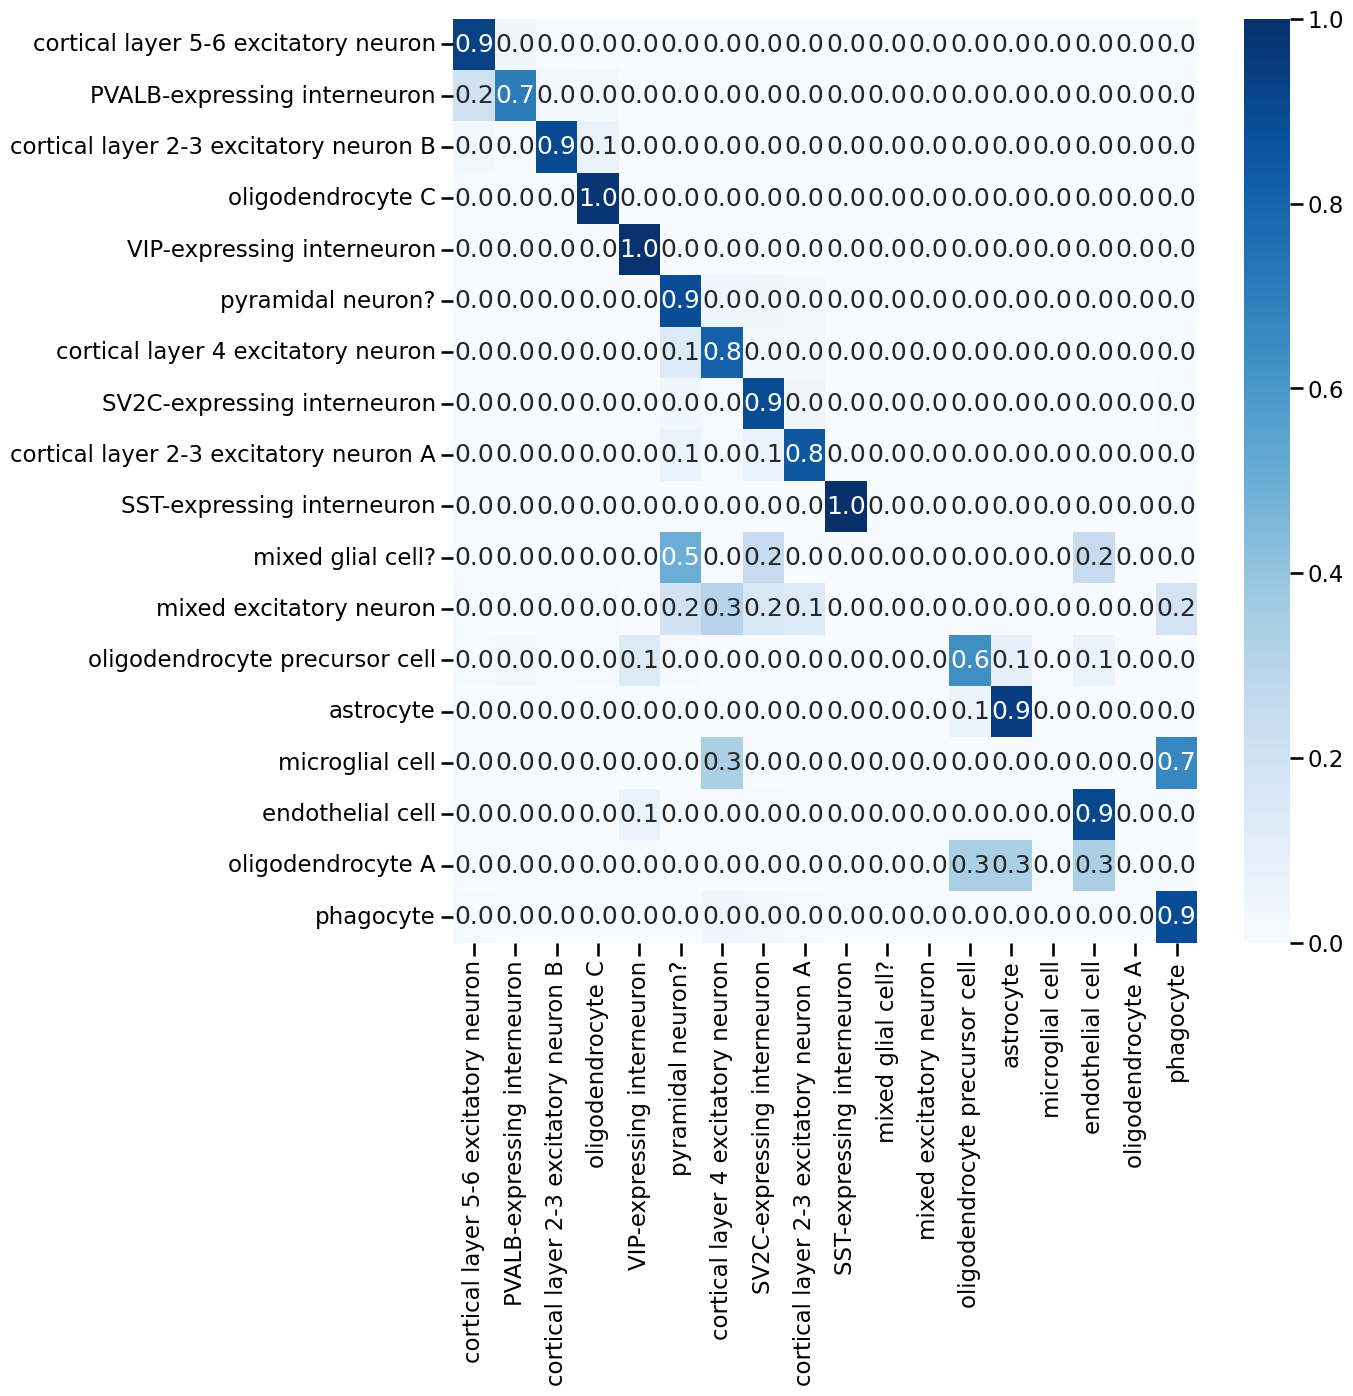

In [32]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

set_predicted_cell_types = list(adata_unseen.obs["celltype"].unique())
for i in set(y_pred_unseen):
    if i not in set_predicted_cell_types:
        set_predicted_cell_types.remove(i)

cm = confusion_matrix(y_true_unseen, y_pred_unseen)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

# Geneformer

As we did with scGPT earlier, we will set up the environment to use a GPU if available, configure the scGPT model, and process the data to obtain the embeddings. For Geneformer, we will need to do a few adjustments: it requires gene names as ensembl IDs `adata.var["ensembl_id"]`, and the number of counts `adata.var["n_counts"]`. Then, we'll train the model and compare their performance.

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['cell_type'] = adata.obs['celltype']
adata.var["ensembl_id"] = adata.var["index_column"]

geneformer_config = GeneformerConfig(batch_size=50, device=device)
geneformer = Geneformer(configurer = geneformer_config)

data_geneformer = geneformer.process_data(adata, gene_names = "ensembl_id")
x_geneformer = geneformer.get_embeddings(data_geneformer)
x_geneformer.shape

File: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/gene_median_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
File saved to: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/gene_median_dictionary.pkl'
File: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/human_gene_to_ensemble_id.pkl' exists already. File is not overwritten and nothing is downloaded.
File saved to: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/human_gene_to_ensemble_id.pkl'
File: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/token_dictionary.pkl' exists already. File is not overwritten and nothing is downloaded.
File saved to: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/token_dictionary.pkl'
File: '/Users/marianaquirogalondono/.cache/helical/models/geneformer/geneformer-12L-30M/config.json' exists already. File is not overwritten and nothing is downloaded.
File saved to: '/Users/maria

(7844, 512)

##### Training the model

In [34]:
head_model_geneformer = head_model
X_train, X_test, y_train, y_test = train_test_split(x_geneformer, y_encoded, test_size=0.1, random_state=42)

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = head_model_geneformer.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/50
111/111 [==============================] - 0s 2ms/step - loss: 3.2657 - f1_score: 0.0431 - val_loss: 2.1546 - val_f1_score: 0.0236
Epoch 2/50
111/111 [==============================] - 0s 1ms/step - loss: 2.2709 - f1_score: 0.0247 - val_loss: 2.0314 - val_f1_score: 0.0236
Epoch 3/50
111/111 [==============================] - 0s 1ms/step - loss: 2.1549 - f1_score: 0.0286 - val_loss: 1.9723 - val_f1_score: 0.0236
Epoch 4/50
111/111 [==============================] - 0s 1ms/step - loss: 2.0881 - f1_score: 0.0356 - val_loss: 1.9196 - val_f1_score: 0.0372
Epoch 5/50
111/111 [==============================] - 0s 1ms/step - loss: 2.0220 - f1_score: 0.0492 - val_loss: 1.8534 - val_f1_score: 0.0521
Epoch 6/50
111/111 [==============================] - 0s 1ms/step - loss: 1.9696 - f1_score: 0.0645 - val_loss: 1.8197 - val_f1_score: 0.0750
Epoch 7/50
111/111 [==============================] - 0s 1ms/step - loss: 1.9078 - f1_score: 0.0907 - val_loss: 1.7211 - val_f1_score: 0.1347
Epoch 

In [35]:
# %tensorboard --logdir logs/fit # uncomment to use tensorboard

##### Loading the unseen evaluation set

In [36]:
adata_unseen.var["ensembl_id"] = adata_unseen.var["index_column"]
adata_unseen.obs['n_counts'] = adata_unseen.X.sum(axis=1)
adata_unseen.obs['cell_type'] = adata_unseen.obs['celltype']
data_unseen_geneformer = geneformer.process_data(adata_unseen, gene_names = "ensembl_id")
x_unseen_geneformer = geneformer.get_embeddings(data_unseen_geneformer)
predictions_nn_unseen_geneformer = head_model_geneformer.predict(x_unseen_geneformer)

/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/helical/models/geneformer/geneformer_tokenizer.py:366: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  filter_pass_loc = np.where(adata.obs.get("filter_pass", 0) == 1)[0]
Anndata has no column attribute 'filter_pass'. Passing all cells for tokenization.
Creating dataset.
Map: 100%|██████████| 7844/7844 [00:00<00:00, 9154.61 examples/s] 
Inference started:
100%|██████████| 157/157 [53:06<00:00, 20.30s/it] 

  1/246 [..............................] - ETA: 5s

246/246 [==============================] - 0s 265us/step


In [37]:
y_true_unseen = np.array(adata_unseen.obs["celltype"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.argmax(predictions_nn_unseen_geneformer, axis=1)]

geneformer_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 58.3%
Evaluation set precision: 52.2%
Evaluation set f1: 45.9%
Evaluation set recall: 47.5%


/Users/marianaquirogalondono/miniconda3/envs/helical-package/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Performance of the supervised approach (Celltypist) VS the foundation models scGPT and Geneformer 

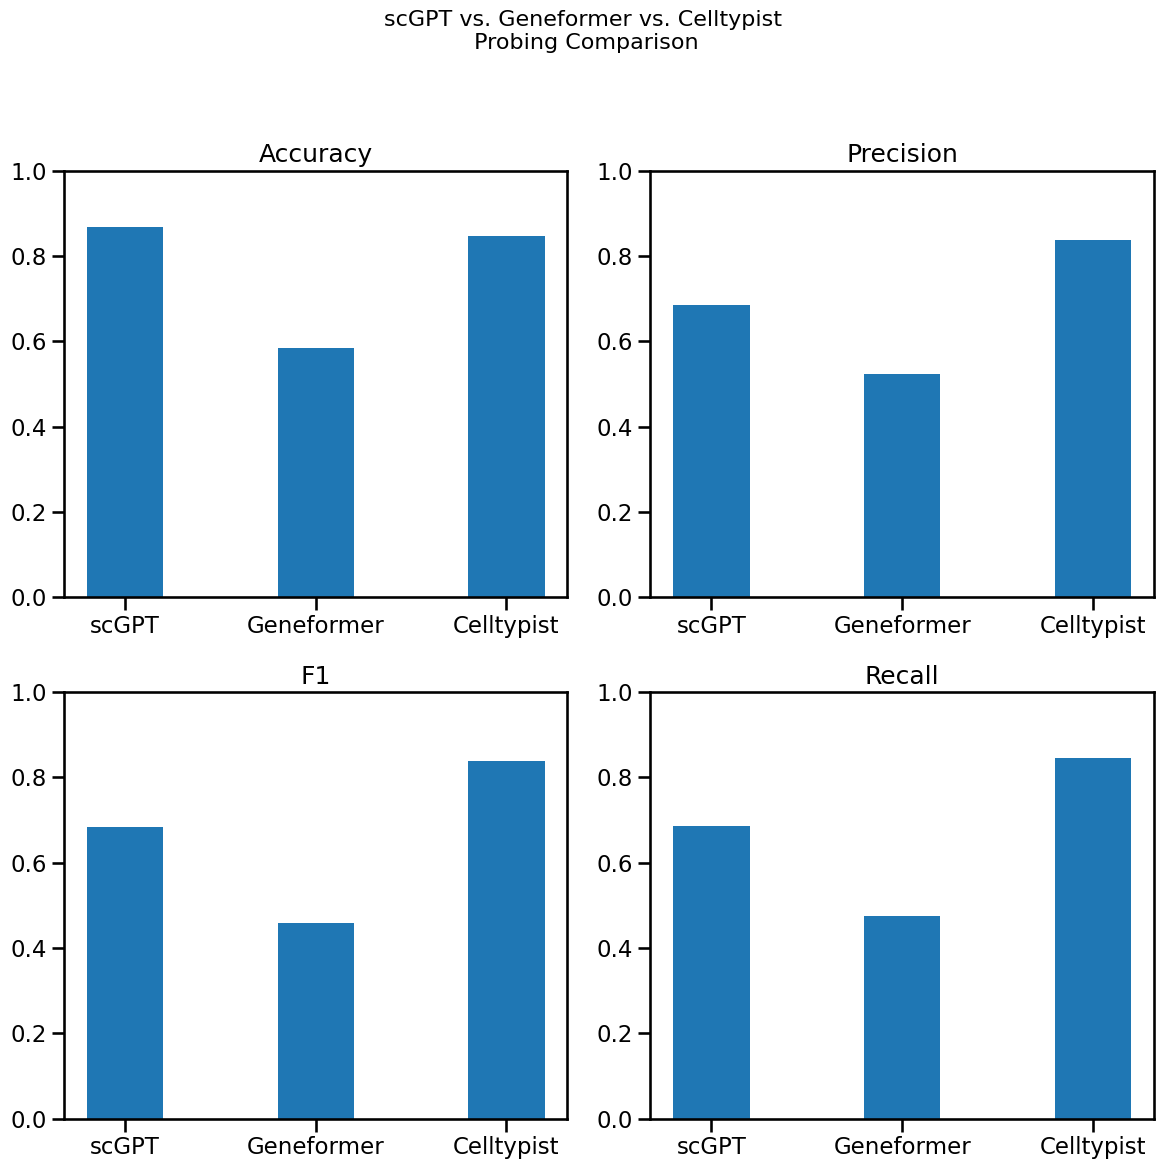

In [38]:
# Create the subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Values for Accuracy
values_1 = [scgpt_results["accuracy"], geneformer_results["accuracy"], celltypist_results["accuracy"]]
x = ["scGPT", "Geneformer", "Celltypist"]
axs[0, 0].bar(x, values_1, width=0.4)
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylim([0, 1])

# Values for Precision
values_2 = [scgpt_results["precision"], geneformer_results["precision"], celltypist_results["precision"]]
axs[0, 1].bar(x, values_2, width=0.4)
axs[0, 1].set_title("Precision")
axs[0, 1].set_ylim([0, 1])

# Values for F1 Score
values_3 = [scgpt_results["f1"], geneformer_results["f1"], celltypist_results["f1_score"]]
axs[1, 0].bar(x, values_3, width=0.4)
axs[1, 0].set_title("F1")
axs[1, 0].set_ylim([0, 1])

# Values for Recall
values_4 = [scgpt_results["recall"], geneformer_results["recall"], celltypist_results["recall"]]
axs[1, 1].bar(x, values_4, width=0.4)
axs[1, 1].set_title("Recall")
axs[1, 1].set_ylim([0, 1])

# Set the overall title
fig.suptitle("scGPT vs. Geneformer vs. Celltypist\n Probing Comparison", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()